In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Описание датасета

- `visit_number` — порядковый номер визита клиента;  
- `utm_source` — источник трафика;  
- `utm_medium` — тип привлечения;  
- `utm_campaign` — рекламная кампания;  
- `utm_adcontent` — содержание объявления;  
- `utm_keyword` — ключевое слово;  
- `device_category` — тип устройства;  
- `device_os` — ОС устройства;  
- `device_brand` — марка устройства;  
- `device_browser` — браузер;  
- `geo_country` — страна;  
- `geo_city` — город;  
- `event_value` — ценность события;  
- `number_of_hits` — количество хитов в сессии;  
- `auto_brand` — марка автомобиля;  
- `auto_model` — модель автомобиля;  
- `screen_size` — размер экрана (в условных единицах);    
- `visit_month` — месяц визита;  
- `visit_day` — день визита;  
- `visit_hour` — час визита;  
- `visit_weekday` — день недели визита;  
- `visit_daytime` — время суток визита;  
- `visit_season` — сезон визита;  
- `traffic` — тип трафика (organic / non-organic);  
- `social_ad` — наличие соц. рекламы (флаг).  

## Feature engineering

In [2]:
df = pd.read_pickle("data/ga_sessions_clean.pkl")
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_value,auto_brand,auto_model
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,1900-01-01 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,android,huawei,360x720,chrome,russia,zlatoust,0.0,unknown_brand,unknown_model
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,1900-01-01 08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,android,samsung,385x854,samsung,russia,moscow,0.0,unknown_brand,unknown_model
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,1900-01-01 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,android,huawei,360x720,chrome,russia,krasnoyarsk,0.0,volkswagen,polo
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,1900-01-01 05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,unknown_campaign,NOBKLgtuvqYWkXQHeYWM,unknown_keyword,mobile,android,xiaomi,393x786,chrome,russia,moscow,0.0,unknown_brand,unknown_model
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,1900-01-01 05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,unknown_campaign,unknown_adcontent,unknown_keyword,mobile,android,xiaomi,393x786,chrome,russia,moscow,0.0,unknown_brand,unknown_model


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1859938 entries, 0 to 1860041
Data columns (total 20 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 object        
 2   visit_date                datetime64[ns]
 3   visit_time                datetime64[ns]
 4   visit_number              int64         
 5   utm_source                object        
 6   utm_medium                object        
 7   utm_campaign              object        
 8   utm_adcontent             object        
 9   utm_keyword               object        
 10  device_category           object        
 11  device_os                 object        
 12  device_brand              object        
 13  device_screen_resolution  object        
 14  device_browser            object        
 15  geo_country               object        
 16  geo_city                  object        
 17  event_value  

In [4]:
#Функция вычисления конверсии
def CR(df, group_col):
    cr = df.groupby(group_col)['event_value'].mean()
    return cr

In [5]:
# Разбиение visit number на бины, создание признака visit_nuber_bins
# Биннинг по диапазонам
bins = [0, 5, 10, 20, 50, 100, 200, 300, df.visit_number.max()]
labels = ["1-5", "6-10", "11-20", "21-50", "51-100", "101-200", "201-300", f"301-{df.visit_number.max()}"]

df["visit_number_bins"] = pd.cut(df["visit_number"], bins=bins, labels=labels, right=True)

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_14740\3740561075.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cr_visit_number_bins = df.groupby("visit_number_bins")["event_value"].mean()


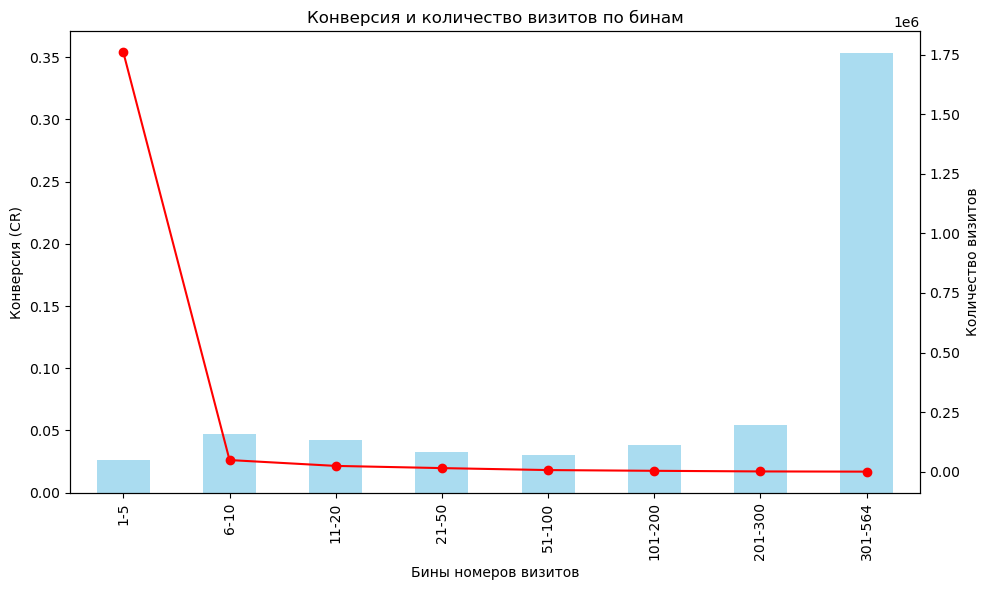

In [6]:
# Считаем конверсию по бинам
cr_visit_number_bins = df.groupby("visit_number_bins")["event_value"].mean()
#Считаем количество визитов в каждом бине
counts = df["visit_number_bins"].value_counts().sort_index()
# Строим график
fig, ax1 = plt.subplots(figsize=(10,6))

# Столбцы — CR
cr_visit_number_bins.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
ax1.set_ylabel("Конверсия (CR)")
ax1.set_xlabel("Бины номеров визитов")
ax1.set_title("Конверсия и количество визитов по бинам")

# Вторая ось — количество визитов
ax2 = ax1.twinx()
counts.plot(kind='line', ax=ax2, color='red', marker='o')
ax2.set_ylabel("Количество визитов")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Конверсия коррелирует с номером визита на сайт. Как видно, количество визитов на сайт примерно одинаковое у всех бинов со 2 по 8, при этом у последнего конверсия резко возрастает. То есть высокая конверсия вызвана не малым количеством данных, а тем что постоянные клиенты чаще совершают целевое действие. 

In [7]:
#Площадь экрана
df['screen_size']=df.device_screen_resolution.apply(lambda x: float(x.split('x')[0]) * float(x.split('x')[1]))

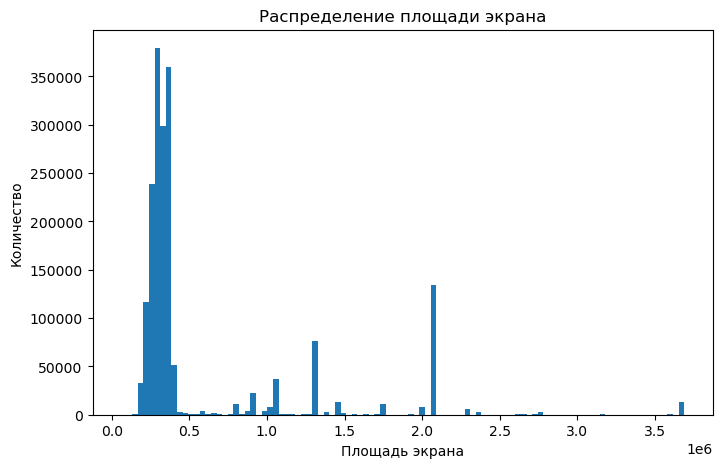

In [8]:
plt.figure(figsize=(8,5))
plt.hist(df['screen_size'], bins=100)
plt.xlabel("Площадь экрана")
plt.ylabel("Количество")
plt.title("Распределение площади экрана")
plt.show()

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_14740\133724748.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cr = df.groupby(group_col)['event_value'].mean()


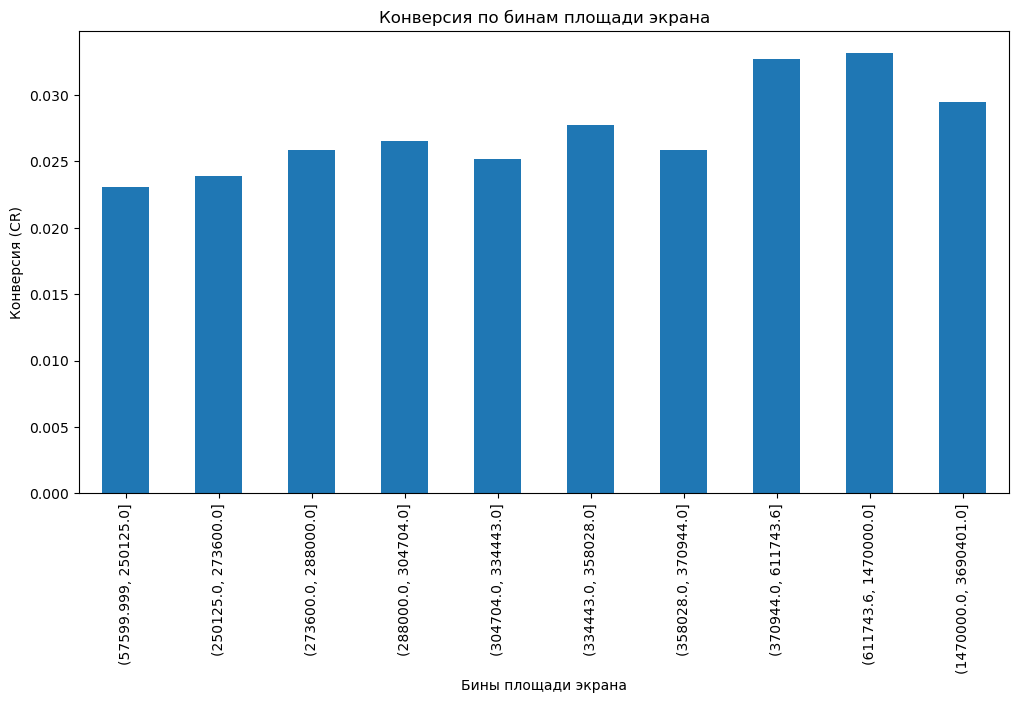

In [9]:
# Биннинг (например, 10 интервалов по квантилям)
df["screen_size_bin"] = pd.qcut(df.screen_size, q=10)

# Конверсия по бинам
cr_screen_size=CR(df, "screen_size_bin")

cr_screen_size.plot(kind="bar", figsize=(12,6))
plt.ylabel("Конверсия (CR)")
plt.xlabel("Бины площади экрана")
plt.title("Конверсия по бинам площади экрана")
plt.show()


Более высокая конверсия у больших экранов

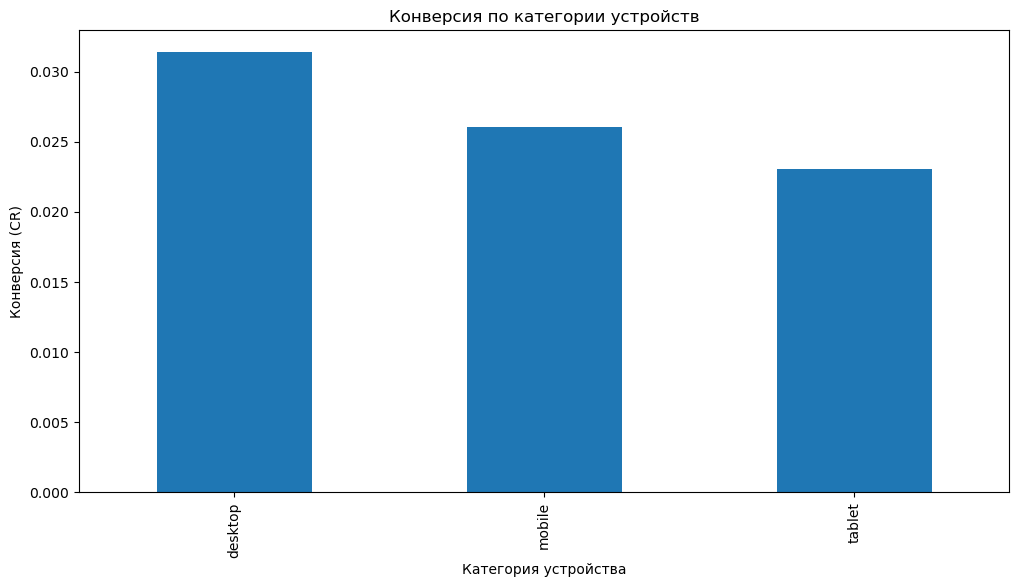

In [10]:
cr_device_categoty = CR(df, "device_category")

cr_device_categoty.plot(kind="bar", figsize=(12,6))
plt.ylabel("Конверсия (CR)")
plt.xlabel("Категория устройства")
plt.title("Конверсия по категории устройств")
plt.show()


Согласуется с прошлым выводом, конверсия выше у десктопных утройств

In [11]:
#Создание признаков по дате и времени
# Базовые временные фичи
df['visit_month']      = df['visit_date'].dt.month
df['visit_day']        = df['visit_date'].dt.day
df['visit_hour']       = df['visit_time'].dt.hour
df['visit_weekday']    = df['visit_date'].dt.dayofweek   # 0=понедельник, 6=воскресенье

# Время суток
def get_daytime(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

df['visit_daytime'] = df['visit_hour'].apply(get_daytime)

# Сезоны
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"

df['visit_season'] = df['visit_month'].apply(get_season)

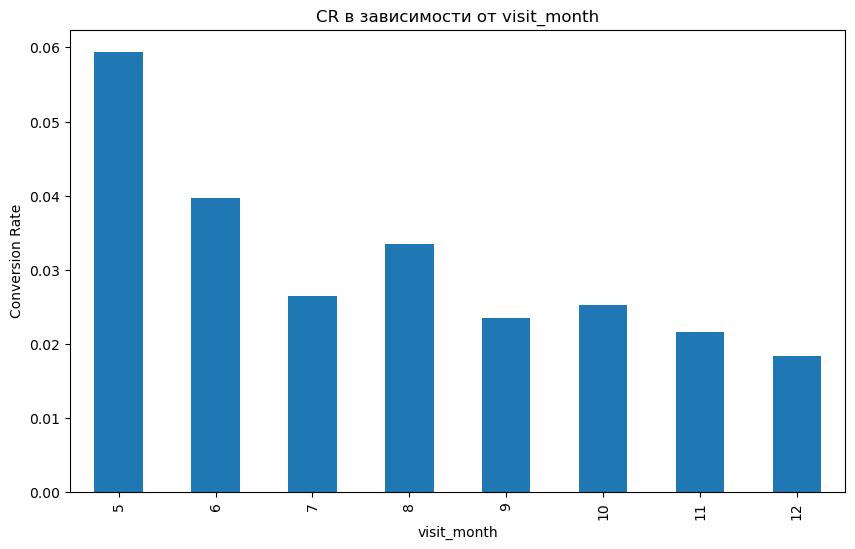

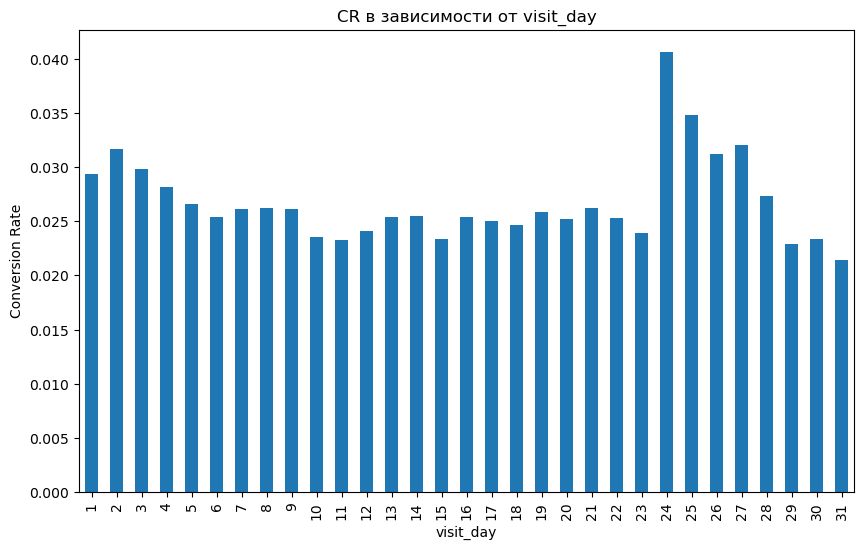

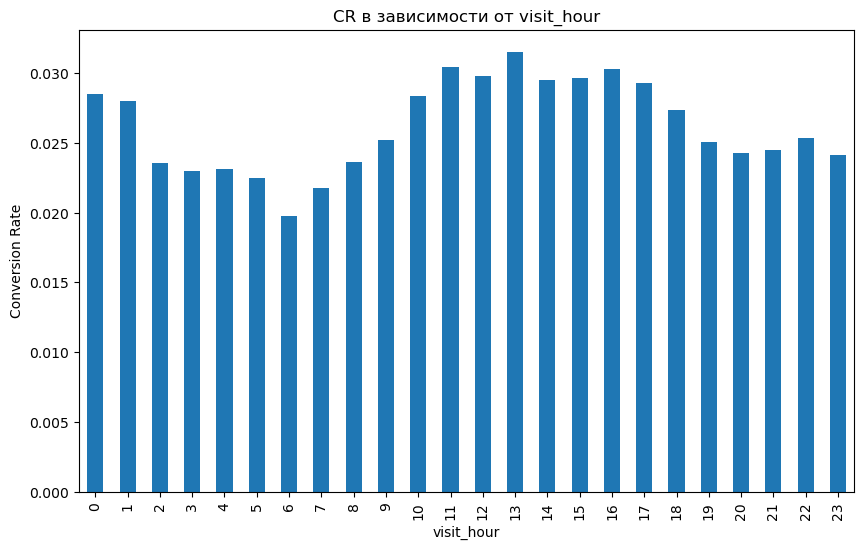

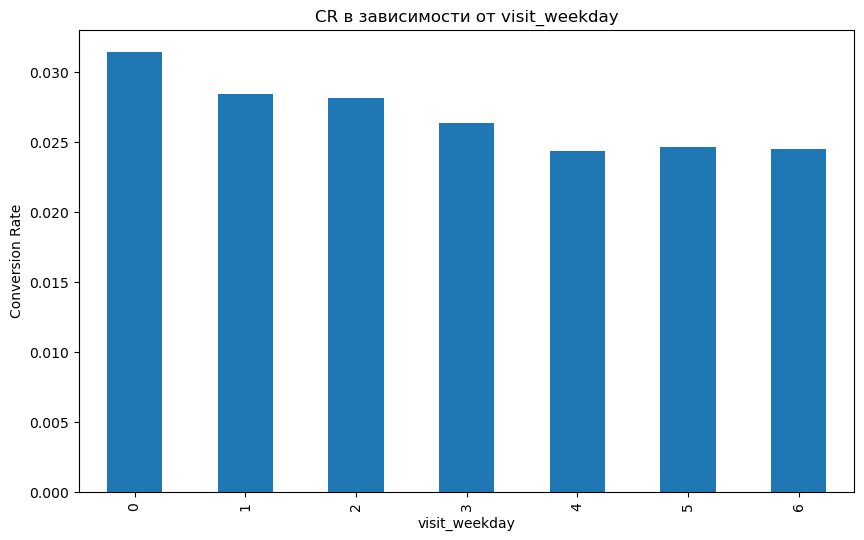

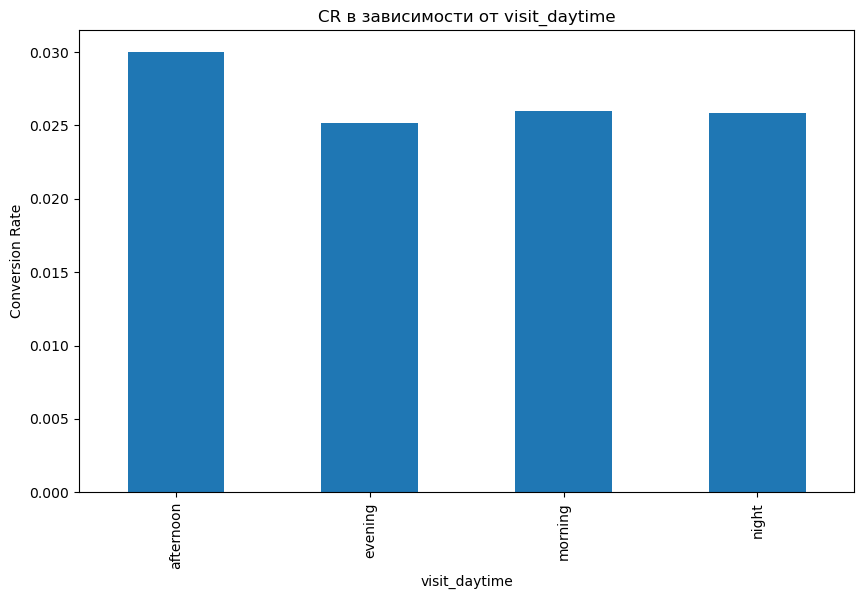

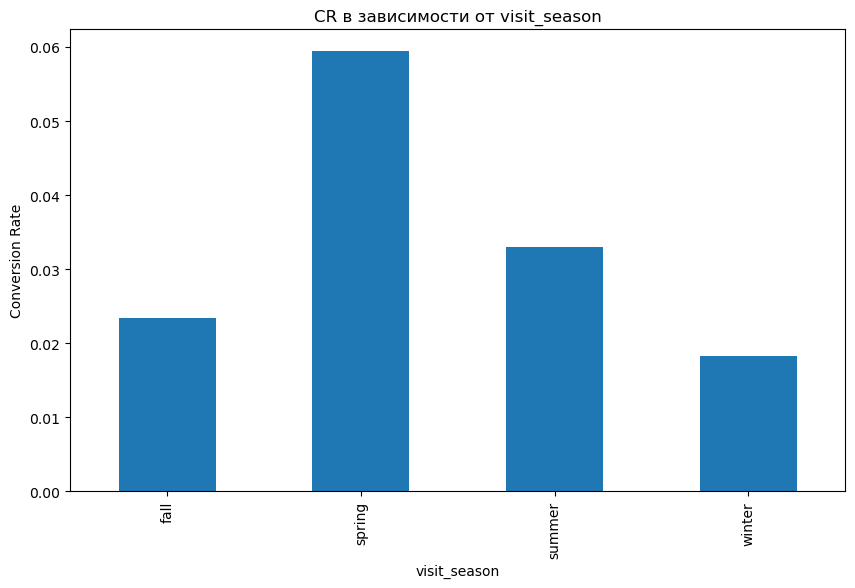

In [12]:
cr_daytime_features = {}

for i in ['visit_month','visit_day','visit_hour','visit_weekday','visit_daytime','visit_season']:
    cr_daytime_features[f"cr_{i}"] = CR(df, i)
    plt.figure(figsize=(10,6))
    cr_daytime_features[f"cr_{i}"].plot(kind="bar")
    plt.ylabel("Conversion Rate")
    plt.xlabel(i)
    plt.title(f"CR в зависимости от {i}")
    plt.show()

Высокая конверсия весной может быть связана с нехваткой данных. Данные только с мая по декабрь, поэтому данные для весны неполные.

In [13]:
#Реклама в социальных сетях
df['social_ad'] = df['utm_source'].apply(lambda x: 1 if x in ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 
                                                                        'ISrKoXQCxqqYvAZICvjs','IZEXUFLARCUMynmHNBGo', 
                                                                        'PlbkrSYoHuZBWfYjYnfw','gVRrcxiDQubJiljoTbGm'] 
                                         else 0)

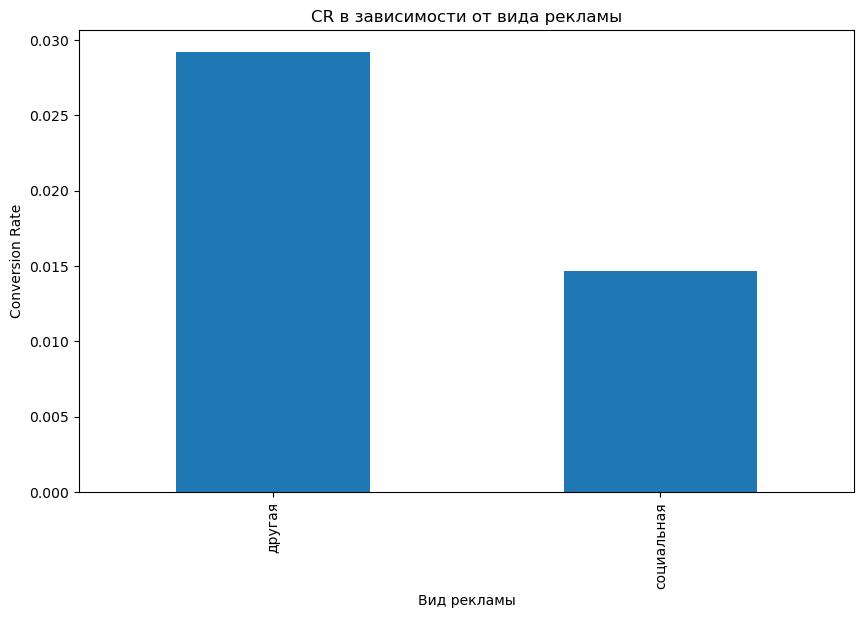

In [14]:
cr_social_ad = CR(df, 'social_ad')

plt.figure(figsize=(10,6))
ax = cr_social_ad.sort_values(ascending=False).plot(kind="bar")
# меняем подписи на оси X
ax.set_xticklabels(['социальная' if x == 1 else 'другая' for x in cr_social_ad.sort_index().index])
plt.ylabel("Conversion Rate")
plt.xlabel("Вид рекламы")
plt.title("CR в зависимости от вида рекламы")
plt.show()

Реклама в соц сетях реже приводит к совершению целевого действия, чем реклама из других источников

In [15]:
#Органический и платный трафик
df['organic_traffic'] = df['utm_medium'].apply(lambda x: 1 if x in ['organic', 'referral', '(none)'] else 0)

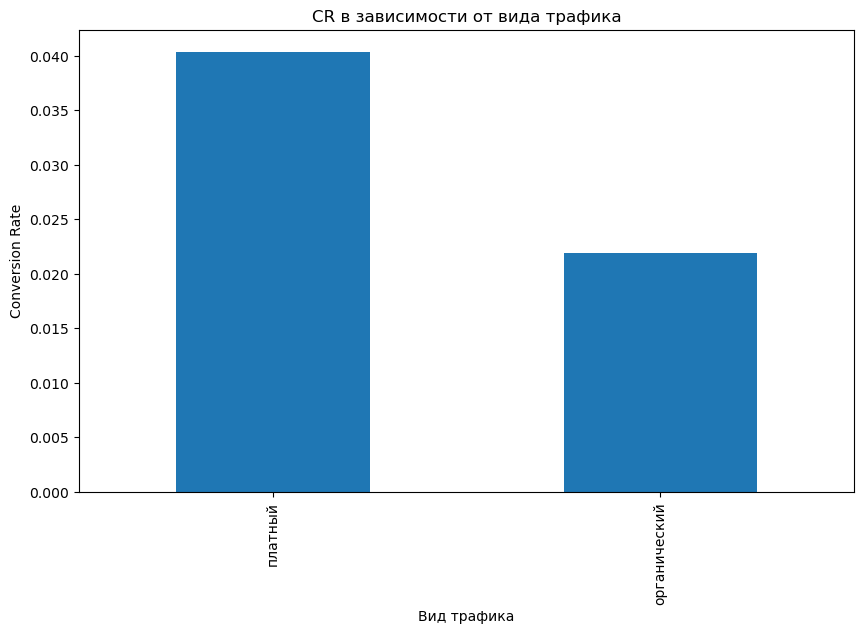

In [16]:
cr_traffic = CR(df, 'organic_traffic')

plt.figure(figsize=(10,6))
ax = cr_traffic.sort_values(ascending=False).plot(kind="bar")
# меняем подписи на оси X
ax.set_xticklabels(['органический' if x == 1 else 'платный' for x in cr_traffic.sort_index().index])
plt.ylabel("Conversion Rate")
plt.xlabel("Вид трафика")
plt.title("CR в зависимости от вида трафика")
plt.show()

In [17]:
df[['visit_hour','visit_day','visit_weekday', 'visit_month']] = df[['visit_hour','visit_day','visit_weekday', 'visit_month']].astype('int64')

In [18]:
#Счетчик уникальных значений по колонкам
df.select_dtypes(include=["object", "category"]).nunique()

session_id                  1859938
client_id                   1391663
utm_source                      293
utm_medium                       55
utm_campaign                    413
utm_adcontent                   287
utm_keyword                    1220
device_category                   3
device_os                        13
device_brand                    205
device_screen_resolution       4943
device_browser                   31
geo_country                     166
geo_city                       2519
auto_brand                       16
auto_model                       44
visit_number_bins                 8
screen_size_bin                  10
visit_daytime                     4
visit_season                      4
dtype: int64

Кодировка:
utm_source, utm_campaign, utm_adcontent, utm_keyword, device_brand, geo_city - FrequencyEncoder из-за большого числа уникальных значений
utm_medium, device_category, device_os, device_browser, geo_country, auto_brand, auto_model, visit_daytime, visit_season, traffic, social_ad - OneHotEncoder

In [19]:
pd.set_option("display.max_rows", None)

In [20]:
#Счетчик уникальных значений
df.utm_source.value_counts()

utm_source
ZpYIoDJMcFzVoPFsHGJL    578380
fDLlAcSmythWSCVMvqvL    300558
kjsLglQLzykiRbcDiGcD    266338
MvfHsxITijuriZxsqZqt    186187
BHcvLfOaCWvWTykYqHVe    116315
bByPQxmDaMXgpHeypKSM    102286
QxAxdyPLuQMEcrdZWdWb     51404
aXQzDWsJuGXeBXexNHjc     31150
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28038
vFcAhRxLfOWKhvxjELkx     24411
PlbkrSYoHuZBWfYjYnfw     20792
hTjLvqNxGggkGnxSCaTm     14598
gDBGzjFKYabGgSPZvrDH     13565
fgymSoTvjKPEgaIJqsiH      9623
geDcueAOghDzHkGMmdOq      8680
ISrKoXQCxqqYvAZICvjs      8632
nSReTmyFtbSjlPrTKoaX      7284
SzZERoLMmrEUEhDaYcyN      6828
eLzNJHzPelJpEyBwMrKo      5386
IZEXUFLARCUMynmHNBGo      4421
iNFgfQPqHPBuvGCYtrQE      3531
oZCzWSykfixnjMPDNjSU      3143
gVRrcxiDQubJiljoTbGm      2767
nmfptFmSirEqNzAzqbXA      2243
GpAkIXsclxDGyILfNlrR      2115
TxKUcPpthBDPieTGmVhx      2093
ghoaGAksqhKomdFrxgyJ      1900
KgicpPxiEQfzPlPwQZJq      1761
nrKihqcWGIzDsOqljdAv      1668
BKeImrJuRDZcHiSSTdzm      1464
DnEUulZAecfGPvdtZBYS      14

In [21]:
# Считаем частоты каждого source
campaign_freq_map = df['utm_source'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['utm_source_freq'] = df['utm_source'].map(campaign_freq_map)

In [22]:
correlation_source = df['utm_source_freq'].corr(df['event_value'])
print(f'Корреляция между source и event_value: {correlation_source}')

Корреляция между source и event_value: 0.008006923185282155


In [23]:
#Счетчик уникальных значений
df.utm_campaign.value_counts()

utm_campaign
LTuZkdKfxRGVceoWkVyg    463458
LEoPHuyFvzoNfnzGgfcd    324039
FTjNLDyTrXaWYgZymFkV    247346
unknown_campaign        219576
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24523
okTXSMadDkjvntEHzIjp     24510
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20187
LwJZxKuWmvOhPsaCeRjG     17615
RoDitORHdzGfGhNCyEMy     15705
bxOTvPtyGSdUrbwoXCPO     15415
zxoiLxhuSIFrCeTLQVWZ     12369
bJJuEXRheRIxXEaYIXqM     12232
YCKgTzTDywjcWyQudGch     12041
nSReTmyFtbSjlPrTKoaX     11611
QEejXfOCtOMFLZqIPApp     10172
vRLTQQKAsFQMxbcHGPhu      9461
jvsVVQVKRfBIqBDBuCkq      7950
eimRuUrNhZLAYcwRrNXu      7784
QdLfySaGXolfTBSNVfHn      7495
VBmazutCflYumtDHrQYe      7465
kVOrIKZFrEYGvixPclal      7059
MXqmDyetMTICSSitTjWV      7038
KgicpPxiEQfzPlPwQZJq      6934
PXQWdUxeUoXfoKzTBGpY      6901
JwYIveaHVpeeRZloQCfF      6548
jqlUOdZBNZYfInQVcZlS      6388
WiILFRDQbcHDHNvHzGpX      5793
IKQsApKuPmZqqmhieEgf      5607
GWZGdHKPgmZPNPwkJshU      

In [24]:
#Группировка редких категорий, до 500 уникальных значений
counts = df["utm_medium"].value_counts()
rare_categories = counts[counts <= 500].index

df["utm_medium"] = df["utm_medium"].replace(rare_categories, "rare_campaign")

In [25]:
# Считаем частоты каждого campaign
campaign_freq_map = df['utm_campaign'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['utm_campaign_freq'] = df['utm_campaign'].map(campaign_freq_map)

In [26]:
correlation_campaign = df['utm_campaign_freq'].corr(df['event_value'])
print(f'Корреляция между campaign и event_value: {correlation_campaign}')

Корреляция между campaign и event_value: 0.04892810250059715


In [27]:
#Счетчик уникальных значений
df.utm_adcontent.value_counts()

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006542
unknown_adcontent        335591
vCIpmpaGBnIQhyYNkXqp     181044
xhoenQgDQsgfEPYNPwKO     113060
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24222
TuyPWsGQruPMpKvRxeBF      18189
UxrnyMlRBSOhOjytXnMG      13583
dUuXlWzvmhDSyclWRhNP      10280
yYdBRbPmBMUZHXwqGxNx       9698
WYLajZgbUhGimwBKDZUH       8610
SOkCdPxfUcZUzzOdgGES       7316
AdeErYgVTbRcAWtHrMHq       6391
nNqUcgFgcqQbTVSvgaHr       6192
aYAcKhelKzYpXrRYknSP       5090
XSkXBCPfnJjvxbfeewtd       4383
XKsYZiUFcdkUXQpoLKyS       4112
FkiRXDLOWtzVfvhEkhNo       2841
xnyHaukLtAvgViiZSyBC       2582
SAVVWaMghGnnvPOqMOIt       2501
guyNoEvzgofQvvwExGOq       2228
LcGIUNPUAmXtQJaDfFBR       2095
qhEmhjPXvwgEHdBikgEQ       1718
NhvfEqcSTGEZKxxvUZlj       1576
sYzBROYhjSDbFZCpzGyf       1538
DZYjhfIUfdqhfuTNUmjn       1460
EteMoEECGsaJeMnuvAZD       1412
eOWmIGTKVDPewucDtZXG       1042
twlfGCnyRPFtCeUKaust       1025
eEkLatVAYTkibdzPIyDi        992
ZKlsrASsGaoEHfwkdKjL      

In [28]:
# Считаем частоты каждого adcontent
adcontent_freq_map = df['utm_adcontent'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['utm_adcontent_freq'] = df['utm_adcontent'].map(adcontent_freq_map)

In [29]:
correlation_adcontent = df['utm_adcontent_freq'].corr(df['event_value'])
print(f'Корреляция между adcontent и event_value: {correlation_adcontent}')

Корреляция между adcontent и event_value: 0.04956318061022152


In [30]:
#Счетчик уникальных значений
df.utm_keyword.value_counts()

utm_keyword
unknown_keyword         1082052
puhZPIYqKXeFPaUviSjo     506762
aXQzDWsJuGXeBXexNHjc      24241
pHqgLcdBQPSLcrTpLkdr      13766
ITfrGJNwVsHBGJMAKoct      13349
hAmNSZmQkKQKAjZEGlgb      11296
UKNBOHebRIIsQRsjNKay      10946
IGUCNvHlhfHpROGclCit       7568
RkpOyeEPgcMBSDuHLQcj       6976
JajANoFxoqXfKRNBUhzx       6758
BmOOOIoWGHEfxEfoUezs       6602
ZNhSIPchlbnKwZWcsKzz       5660
pucKZkLDtpMDBTobJAJG       5391
RrhnkuoaqckNtJpAZDzH       5004
YQXPpoLsxnykCWKhGEmI       4872
DBHgBJHOdbPwsRDUbEgX       4470
tVtbIKrPSOvrXLCznVVe       3710
XEayFbemrPYbxFeNbxif       3695
MWLEpQPyjGkjHseVyeyQ       3154
fzbotReoFzSuckjwcpCs       2965
COtBsnAzfZyRVtvDlhnW       2785
tzIeQUUHahhBuEkJqDVp       2699
QYfbqJXuLdJGfOSFgZOs       2674
KCcEkEaKEtUilBVMoCAi       2637
ISrKoXQCxqqYvAZICvjs       2559
psjAUzFZVWWCuxgCrtmQ       2544
qxnAydKMtMSuafVrMzdC       2539
ObIWuFTMgFPUHNiFoOwb       2491
MBHgRPNeTcONuVFFXgmz       2476
oKjXDUsycmahkgMhGdAR       2385
qUcotcWimEOQiboVPcCx       2

In [31]:
# Считаем частоты каждого keyword
keyword_freq_map = df['utm_keyword'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['utm_keyword_freq'] = df['utm_keyword'].map(keyword_freq_map)

In [32]:
correlation_keyword = df['utm_keyword_freq'].corr(df['event_value'])
print(f'Корреляция между keyword и event_value: {correlation_keyword}')

Корреляция между keyword и event_value: 0.03677381780041424


In [33]:
#Счетчик уникальных значений
df.device_brand.value_counts()

device_brand
apple             551045
unknown_brand     384686
samsung           332185
xiaomi            288357
huawei            185850
realme             19058
oppo               13504
vivo               11739
oneplus             9965
asus                7929
nokia               7285
sony                6459
zte                 6365
google              5150
meizu               3750
lenovo              3148
blackview           2759
tecno               2653
lg                  2447
motorola            2357
bq                  1573
itel                1082
alcatel              968
doogee               876
oukitel              826
htc                  790
umidigi              661
ulefone              511
infinix              417
vsmart               368
leeco                344
blackberry           338
cubot                320
philips              299
mozilla              295
poco                 229
sharp                226
vertex               198
tp-link              194
dexp        

In [34]:
# Считаем частоты каждого brand
brand_freq_map = df['device_brand'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['device_brand_freq'] = df['device_brand'].map(brand_freq_map)

In [35]:
correlation_brand = df['device_brand_freq'].corr(df['event_value'])
print(f'Корреляция между device_brand и event_value: {correlation_brand}')

Корреляция между device_brand и event_value: 0.005890587274416383


In [36]:
#Счетчик уникальных значений
df.geo_city.value_counts()

geo_city
moscow                          805269
saint petersburg                296779
unknown_city                     78458
yekaterinburg                    35787
krasnodar                        32243
kazan                            29531
samara                           24992
nizhny novgorod                  22226
ufa                              21679
novosibirsk                      21568
krasnoyarsk                      16346
chelyabinsk                      15951
tula                             15813
voronezh                         13908
rostov-on-don                    13886
irkutsk                          13532
grozny                           12742
balashikha                       12679
vladivostok                      12325
yaroslavl                         9833
sochi                             8972
tyumen                            8534
khimki                            7383
saratov                           7120
perm                              6293
vidnoye         

In [37]:
# Считаем частоты каждого city
city_freq_map = df['geo_city'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['geo_city_freq'] = df['geo_city'].map(city_freq_map)

In [38]:
correlation_city = df['geo_city_freq'].corr(df['event_value'])
print(f'Корреляция между geo_city и event_value: {correlation_city}')

Корреляция между geo_city и event_value: 0.010790093719020856


In [39]:
#Стандартизация числовых признаков
numerical_vars = ['visit_number','screen_size']
std_scaler = StandardScaler()
std_scaler.fit(df[numerical_vars])
numerical_scaled= std_scaler.transform(df[numerical_vars])
numerical_vars_std_scaled = []
for i in numerical_vars:
    numerical_vars_std_scaled.append(i + '_std')
df[numerical_vars_std_scaled] = numerical_scaled
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,social_ad,organic_traffic,utm_source_freq,utm_campaign_freq,utm_adcontent_freq,utm_keyword_freq,device_brand_freq,geo_city_freq,visit_number_std,screen_size_std
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,1900-01-01 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0,0,0.310967,0.174220,0.097339,0.272462,0.099923,0.000120,-0.144788,-0.528096
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,1900-01-01 08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,1,0,0.100104,0.132986,0.060787,0.004069,0.178600,0.432955,-0.144788,-0.414732
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,1900-01-01 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0,0,0.310967,0.174220,0.097339,0.272462,0.099923,0.008788,-0.144788,-0.528096
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,1900-01-01 05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,unknown_campaign,NOBKLgtuvqYWkXQHeYWM,unknown_keyword,...,0,0,0.143197,0.118056,0.000394,0.581768,0.155036,0.432955,-0.144788,-0.447137
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,1900-01-01 05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,unknown_campaign,unknown_adcontent,unknown_keyword,...,0,0,0.143197,0.118056,0.180431,0.581768,0.155036,0.432955,-0.060248,-0.447137


In [40]:
#Циклическое представление дат
df["visit_day_sin"] = np.sin(2 * np.pi * df["visit_day"] / df["visit_day"].max())
df["visit_day_cos"] = np.cos(2 * np.pi * df["visit_day"] / df["visit_day"].max())

df["visit_hour_sin"] = np.sin(2 * np.pi * df["visit_hour"] / df["visit_hour"].max())
df["visit_hour_cos"] = np.cos(2 * np.pi * df["visit_hour"] / df["visit_hour"].max())

df["visit_weekday_sin"] = np.sin(2 * np.pi * df["visit_weekday"] / df["visit_weekday"].max())
df["visit_weekday_cos"] = np.cos(2 * np.pi * df["visit_weekday"] / df["visit_weekday"].max())

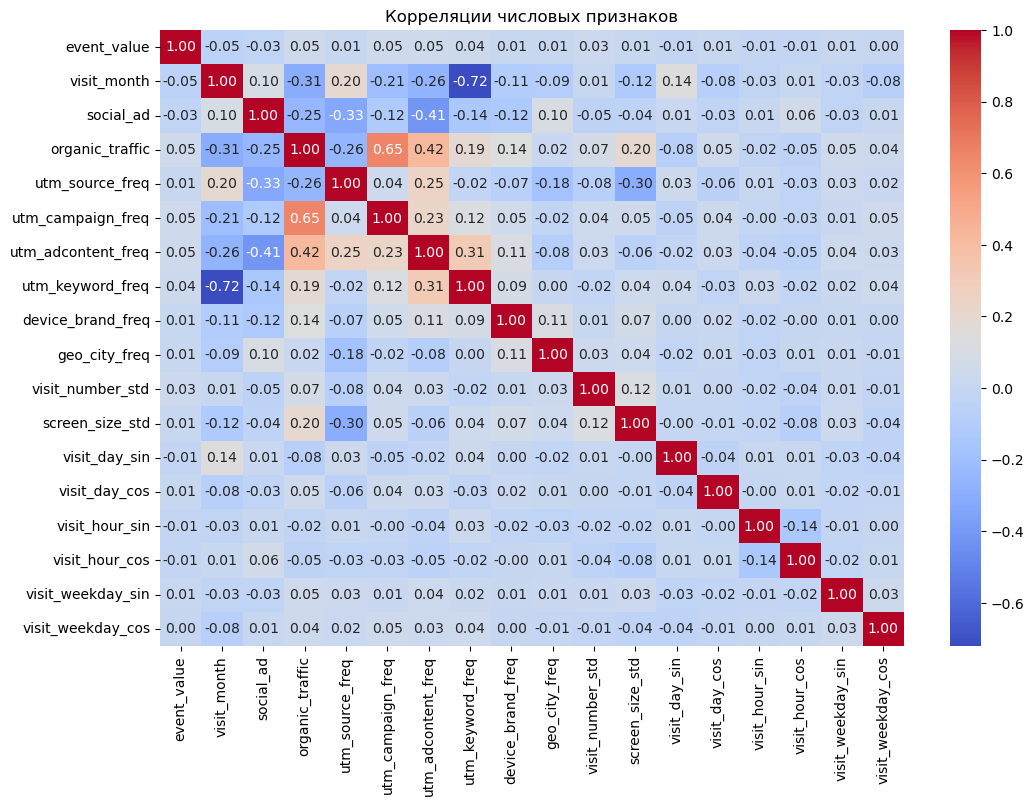

In [41]:
#Корреляция числовых признаков

# Берём только числовые фичи
num_cols = ['event_value', 'visit_month', 'social_ad', 'organic_traffic',
       'utm_source_freq', 'utm_campaign_freq', 'utm_adcontent_freq',
       'utm_keyword_freq', 'device_brand_freq', 'geo_city_freq',
       'visit_number_std', 'screen_size_std', 'visit_day_sin', 
        'visit_day_cos', 'visit_hour_sin', 'visit_hour_cos',
       'visit_weekday_sin', 'visit_weekday_cos']

plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляции числовых признаков")
plt.show()

Большинство корреляций низкие, т.е. нет сильных линейных зависимостей с целевым действием.

Объяснение заметных корреляций других признаков:
- traffic ~ utm_campaign_freq
Трафик зависит от рекламных кампаний, чем чаще встречается конкретная кампания, тем выше вероятность неорганического трафика.
- traffic ~ utm_adcontent_freq
Реклама и конкретные виды объявлений влияют на трафик
- utm_campaign_freq ~ utm_adcontent_freq
Кампании и объявления взаимосвязаны, внутри одной кампании используется ограниченный набор объявлений.
- utm_source_freq ~ utm_adcontent_freq
Разные источники редко делят один и тот же контент, то есть каналы чётко разделены по рекламным материалам.
- utm_source_freq ~ visit_month
Источники трафика зависят от месяца, может быть есть сезонные каналы.
- utm_keyword_freq ~ utm_adcontent_freq
Ключевые слова связаны с креативами, определённые слова используются в одних и тех же объявлениях.
- utm_keyword_freq ~ visit_month
Очень сильная отрицательная корреляция. Значит, ключевые слова сильно зависит от месяца, есть сезонность.


OneHotEncoder

In [42]:
#Счетчик уникальных значений
df.utm_medium.value_counts()

utm_medium
banner             552743
cpc                434740
(none)             300558
cpm                242068
referral           152045
organic             63034
email               29240
push                28034
stories             10582
cpv                  8022
blogger_channel      8015
smartbanner          6794
blogger_stories      4312
cpa                  4279
tg                   4011
app                  2836
post                 2326
smm                  1984
outlook              1331
rare_campaign        1280
clicks                933
blogger_header        771
Name: count, dtype: int64

In [43]:
#Группировка редких категорий, до 500 уникальных значений
counts = df["utm_medium"].value_counts()
rare_categories = counts[counts <= 500].index

df["utm_medium"] = df["utm_medium"].replace(rare_categories, "rare_medium")

In [44]:
#Счетчик уникальных значений
df.utm_medium.value_counts()

utm_medium
banner             552743
cpc                434740
(none)             300558
cpm                242068
referral           152045
organic             63034
email               29240
push                28034
stories             10582
cpv                  8022
blogger_channel      8015
smartbanner          6794
blogger_stories      4312
cpa                  4279
tg                   4011
app                  2836
post                 2326
smm                  1984
outlook              1331
rare_campaign        1280
clicks                933
blogger_header        771
Name: count, dtype: int64

In [45]:
#Счетчик уникальных значений
df.device_category.value_counts()

device_category
mobile     1474805
desktop     366826
tablet       18307
Name: count, dtype: int64

In [46]:
#Счетчик уникальных значений
df.device_os.value_counts()

device_os
android          933305
ios              551012
unknown_os       257234
windows           88288
macintosh         24849
linux              5119
chrome os            83
blackberry           27
tizen                 7
samsung               4
windows phone         4
firefox os            3
nokia                 3
Name: count, dtype: int64

In [47]:
#Оставляем только первое слово в названии браузера
df.device_os = df.device_os.str.split(' ').str[0]

In [48]:
#Счетчик уникальных значений
df.device_os.value_counts()

device_os
android       933305
ios           551012
unknown_os    257234
windows        88292
macintosh      24849
linux           5119
chrome            83
blackberry        27
tizen              7
samsung            4
firefox            3
nokia              3
Name: count, dtype: int64

In [49]:
#Счетчик уникальных значений
df.device_browser.value_counts()

device_browser
chrome        1013418
safari         548425
yabrowser      133299
android         55831
samsung         47307
opera           26862
firefox         16586
edge            16062
uc                871
instagram         396
mozilla           379
fban              269
mrchrome           77
puffin             45
internet           36
maxthon            31
vkclient            8
amazon              7
coc                 6
helloworld          6
seamonkey           4
iron                2
netfront            2
myapp               2
mttd                1
nokiax              1
nokia               1
phantom             1
musically           1
konqueror           1
threads             1
Name: count, dtype: int64

In [50]:
#Группировка редких категорий, до 1000 уникальных значений
counts = df["device_browser"].value_counts()
rare_categories = counts[counts <= 1000].index

df["device_browser"] = df["device_browser"].replace(rare_categories, "rare_device_browsers")

In [51]:
#Счетчик уникальных значений
df.device_browser.value_counts()

device_browser
chrome                  1013418
safari                   548425
yabrowser                133299
android                   55831
samsung                   47307
opera                     26862
firefox                   16586
edge                      16062
rare_device_browsers       2148
Name: count, dtype: int64

In [52]:
#Счетчик уникальных значений
df.geo_country.value_counts()

geo_country
russia                      1800462
united states                 11784
ukraine                        9012
ireland                        4034
belarus                        3636
sweden                         2694
kazakhstan                     2279
germany                        2232
turkey                         1953
netherlands                    1548
uzbekistan                     1523
united kingdom                 1462
nan                            1146
kyrgyzstan                      974
georgia                         935
france                          790
cyprus                          765
armenia                         681
finland                         643
spain                           599
poland                          556
united arab emirates            473
israel                          429
tajikistan                      400
moldova                         385
latvia                          357
italy                           355
egypt           

In [53]:
#Группировка редких катгорий, до 300 уникальных значений
counts = df["geo_country"].value_counts()
rare_countries = counts[counts <= 300].index

df["geo_country"] = df["geo_country"].replace(rare_countries, "rare_countries")
df["geo_country"] = df["geo_country"].str.replace(' ', "_")

In [54]:
#Счетчик уникальных значений
df.geo_country.value_counts()

geo_country
russia                  1800462
united_states             11784
ukraine                    9012
rare_countries             6863
ireland                    4034
belarus                    3636
sweden                     2694
kazakhstan                 2279
germany                    2232
turkey                     1953
netherlands                1548
uzbekistan                 1523
united_kingdom             1462
nan                        1146
kyrgyzstan                  974
georgia                     935
france                      790
cyprus                      765
armenia                     681
finland                     643
spain                       599
poland                      556
united_arab_emirates        473
israel                      429
tajikistan                  400
moldova                     385
latvia                      357
italy                       355
egypt                       330
azerbaijan                  328
greece                      

In [55]:
#Счетчик уникальных значений
df.auto_brand.value_counts()

auto_brand
unknown_brand    1337300
skoda             171250
volkswagen         85930
kia                60161
renault            47193
toyota             28146
nissan             27906
lexus              19914
bmw                18633
haval              16655
volvo              13017
porsche            12371
audi                8080
mini                6678
peugeot             6099
hyundai              605
Name: count, dtype: int64

In [56]:
#Счетчик уникальных значений
df.auto_model.value_counts()

auto_model
unknown_model    1337300
rapid              93872
polo               65780
karoq              48956
qashqai            27906
rio                26411
duster             23937
logan              23211
octavia            21216
camry              18464
seltos             17506
jolion             16655
sorento            14423
s90                13017
rx                 10645
tiguan             10082
nx                  9269
cayenne             7306
kodiaq              7206
x3                  6981
hatch               6678
touareg             6380
traveller           6099
x5                  5431
911                 5041
fortuner            4894
a3                  4025
x6                  3849
alphard             3497
q5                  3150
teramont            3137
x7                  2372
corolla             1291
soul                 981
a4                   905
cerato               717
solaris              605
taos                 503
sportage             118
passat        

In [57]:
#Счетчик уникальных значений
df.visit_daytime.value_counts()

visit_daytime
afternoon    626176
evening      576316
morning      457304
night        200142
Name: count, dtype: int64

In [58]:
#Счетчик уникальных значений
df.visit_season.value_counts()

visit_season
fall      836804
summer    515869
winter    399063
spring    108202
Name: count, dtype: int64

In [59]:
ohe = OneHotEncoder(sparse_output = False) 

In [60]:
#Колонки для кодирования OneHot
cols = ['utm_medium','device_category', 'device_os', 'device_browser','geo_country',
        'auto_model','auto_brand','visit_daytime','visit_season']

In [61]:
#Замена всех пробелов на _, чтобы не было пробелов в названии признаков
def replace_spaces_in_columns(df, cols):
    df = df.copy()
    for col in cols:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: x.replace(" ", "_") if isinstance(x, str) else x)
    return df

df = replace_spaces_in_columns(df, cols)

In [62]:
# Обучаем и преобразуем
ohe_categories = ohe.fit_transform(df[cols])

In [63]:
# Делаем DataFrame с новыми колонками
ohe_df = pd.DataFrame(ohe_categories, columns=ohe.get_feature_names_out(cols), index=df.index)
# Склеиваем с исходным датафреймом
df = pd.concat([df, ohe_df], axis=1)

In [64]:
pd.set_option("display.max_columns", None)
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_value,auto_brand,auto_model,visit_number_bins,screen_size,screen_size_bin,visit_month,visit_day,visit_hour,visit_weekday,visit_daytime,visit_season,social_ad,organic_traffic,utm_source_freq,utm_campaign_freq,utm_adcontent_freq,utm_keyword_freq,device_brand_freq,geo_city_freq,visit_number_std,screen_size_std,visit_day_sin,visit_day_cos,visit_hour_sin,visit_hour_cos,visit_weekday_sin,visit_weekday_cos,utm_medium_(none),utm_medium_app,utm_medium_banner,utm_medium_blogger_channel,utm_medium_blogger_header,utm_medium_blogger_stories,utm_medium_clicks,utm_medium_cpa,utm_medium_cpc,utm_medium_cpm,utm_medium_cpv,utm_medium_email,utm_medium_organic,utm_medium_outlook,utm_medium_post,utm_medium_push,utm_medium_rare_campaign,utm_medium_referral,utm_medium_smartbanner,utm_medium_smm,utm_medium_stories,utm_medium_tg,device_category_desktop,device_category_mobile,device_category_tablet,device_os_android,device_os_blackberry,device_os_chrome,device_os_firefox,device_os_ios,device_os_linux,device_os_macintosh,device_os_nokia,device_os_samsung,device_os_tizen,device_os_unknown_os,device_os_windows,device_browser_android,device_browser_chrome,device_browser_edge,device_browser_firefox,device_browser_opera,device_browser_rare_device_browsers,device_browser_safari,device_browser_samsung,device_browser_yabrowser,geo_country_armenia,geo_country_azerbaijan,geo_country_belarus,geo_country_cyprus,geo_country_egypt,geo_country_finland,geo_country_france,geo_country_georgia,geo_country_germany,geo_country_greece,geo_country_ireland,geo_country_israel,geo_country_italy,geo_country_kazakhstan,geo_country_kyrgyzstan,geo_country_latvia,geo_country_moldova,geo_country_nan,geo_country_netherlands,geo_country_poland,geo_country_rare_countries,geo_country_russia,geo_country_spain,geo_country_sweden,geo_country_tajikistan,geo_country_turkey,geo_country_ukraine,geo_country_united_arab_emirates,geo_country_united_kingdom,geo_country_united_states,geo_country_uzbekistan,auto_model_911,auto_model_a3,auto_model_a4,auto_model_alphard,auto_model_arkana,auto_model_camry,auto_model_cayenne,auto_model_cerato,auto_model_corolla,auto_model_duster,auto_model_fortuner,auto_model_hatch,auto_model_jolion,auto_model_k5,auto_model_karoq,auto_model_kodiaq,auto_model_logan,auto_model_macan,auto_model_nx,auto_model_octavia,auto_model_panamera,auto_model_passat,auto_model_polo,auto_model_q5,auto_model_qashqai,auto_model_rapid,auto_model_rio,auto_model_rx,auto_model_s90,auto_model_seltos,auto_model_solaris,auto_model_sorento,auto_model_soul,auto_model_sportage,auto_model_taos,auto_model_teramont,auto_model_tiguan,auto_model_touareg,auto_model_traveller,auto_model_unknown_model,auto_model_x3,auto_model_x5,auto_model_x6,auto_model_x7,auto_brand_audi,auto_brand_bmw,auto_brand_haval,auto_brand_hyundai,auto_brand_kia,auto_brand_lexus,auto_brand_mini,auto_brand_nissan,auto_brand_peugeot,auto_brand_porsche,auto_brand_renault,auto_brand_skoda,auto_brand_toyota,auto_brand_unknown_brand,auto_brand_volkswagen,auto_brand_volvo,visit_daytime_afternoon,visit_daytime_evening,visit_daytime_morning,visit_daytime_night,visit_season_fall,visit_season_spring,visit_season_summer,visit_season_winter
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,1900-01-01 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,android,huawei,360x720,chrome,russia,zlatoust,0.0,unknown_brand,unknown_model,1-5,259200.0,"(250125.0, 273600.0]",11,24,14,2,afternoon,fall,0,0,0.310967,0.174220,0.097339,0.272462,0.099923,0.000120,-0.144788,-0.528096,-0.988468,0.151428,-0.631088,-0.775711,8.660254e-01,-0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [65]:
#Колонки на удаление, удаляем вспомогательные и сырые колонки
columns_to_drop = ['session_id','client_id','visit_date','visit_time','visit_number', 'utm_source',
                   'utm_medium','utm_campaign','utm_adcontent','utm_keyword', 'device_category', 'device_os',
                   'device_brand','device_screen_resolution','device_browser', 'geo_country','geo_city',
                   'auto_brand', 'auto_model','visit_number_bins','screen_size', 'screen_size_bin', 
                   'visit_day','visit_hour','visit_weekday', 'visit_daytime', 'visit_season']
df = df.drop(columns_to_drop, axis = 1)

In [66]:
pd.set_option("display.max_columns", None)
df.head()

,event_value,visit_month,social_ad,organic_traffic,utm_source_freq,utm_campaign_freq,utm_adcontent_freq,utm_keyword_freq,device_brand_freq,geo_city_freq,visit_number_std,screen_size_std,visit_day_sin,visit_day_cos,visit_hour_sin,visit_hour_cos,visit_weekday_sin,visit_weekday_cos,utm_medium_(none),utm_medium_app,utm_medium_banner,utm_medium_blogger_channel,utm_medium_blogger_header,utm_medium_blogger_stories,utm_medium_clicks,utm_medium_cpa,utm_medium_cpc,utm_medium_cpm,utm_medium_cpv,utm_medium_email,utm_medium_organic,utm_medium_outlook,utm_medium_post,utm_medium_push,utm_medium_rare_campaign,utm_medium_referral,utm_medium_smartbanner,utm_medium_smm,utm_medium_stories,utm_medium_tg,device_category_desktop,device_category_mobile,device_category_tablet,device_os_android,device_os_blackberry,device_os_chrome,device_os_firefox,device_os_ios,device_os_linux,device_os_macintosh,device_os_nokia,device_os_samsung,device_os_tizen,device_os_unknown_os,device_os_windows,device_browser_android,device_browser_chrome,device_browser_edge,device_browser_firefox,device_browser_opera,device_browser_rare_device_browsers,device_browser_safari,device_browser_samsung,device_browser_yabrowser,geo_country_armenia,geo_country_azerbaijan,geo_country_belarus,geo_country_cyprus,geo_country_egypt,geo_country_finland,geo_country_france,geo_country_georgia,geo_country_germany,geo_country_greece,geo_country_ireland,geo_country_israel,geo_country_italy,geo_country_kazakhstan,geo_country_kyrgyzstan,geo_country_latvia,geo_country_moldova,geo_country_nan,geo_country_netherlands,geo_country_poland,geo_country_rare_countries,geo_country_russia,geo_country_spain,geo_country_sweden,geo_country_tajikistan,geo_country_turkey,geo_country_ukraine,geo_country_united_arab_emirates,geo_country_united_kingdom,geo_country_united_states,geo_country_uzbekistan,auto_model_911,auto_model_a3,auto_model_a4,auto_model_alphard,auto_model_arkana,auto_model_camry,auto_model_cayenne,auto_model_cerato,auto_model_corolla,auto_model_duster,auto_model_fortuner,auto_model_hatch,auto_model_jolion,auto_model_k5,auto_model_karoq,auto_model_kodiaq,auto_model_logan,auto_model_macan,auto_model_nx,auto_model_octavia,auto_model_panamera,auto_model_passat,auto_model_polo,auto_model_q5,auto_model_qashqai,auto_model_rapid,auto_model_rio,auto_model_rx,auto_model_s90,auto_model_seltos,auto_model_solaris,auto_model_sorento,auto_model_soul,auto_model_sportage,auto_model_taos,auto_model_teramont,auto_model_tiguan,auto_model_touareg,auto_model_traveller,auto_model_unknown_model,auto_model_x3,auto_model_x5,auto_model_x6,auto_model_x7,auto_brand_audi,auto_brand_bmw,auto_brand_haval,auto_brand_hyundai,auto_brand_kia,auto_brand_lexus,auto_brand_mini,auto_brand_nissan,auto_brand_peugeot,auto_brand_porsche,auto_brand_renault,auto_brand_skoda,auto_brand_toyota,auto_brand_unknown_brand,auto_brand_volkswagen,auto_brand_volvo,visit_daytime_afternoon,visit_daytime_evening,visit_daytime_morning,visit_daytime_night,visit_season_fall,visit_season_spring,visit_season_summer,visit_season_winter
0,0.0,11,0,0,0.310967,0.174220,0.097339,0.272462,0.099923,0.000120,-0.144788,-0.528096,-0.988468,0.151428,-0.631088,-0.775711,8.660254e-01,-0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,11,1,0,0.100104,0.132986,0.060787,0.004069,0.178600,0.432955,-0.144788,-0.414732,0.299363,-0.954139,0.816970,-0.576680,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [67]:
#Сохранение датафрейма
df.to_pickle("data/ga_sessions_prepared.pkl")